<a href="https://colab.research.google.com/github/DarShabi/OCR-Company-Project/blob/main/Week%231/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob
import json
from collections import Counter, defaultdict
import re
import matplotlib.image as mpimg
import seaborn as sns


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
root_folder = "/content/drive/MyDrive/Data/Data_samples"

# EDA Functions

In [4]:
def load_images_and_annotations_from_folders(root_folder):
    """
    Loads all images and corresponding JSON annotations from subfolders.

    Parameters:
    root_folder (str): Path to the root folder.

    Returns:
    list, list: A list of paths to the images and a list of corresponding annotations (dictionaries).
    """
    img_paths = []
    texts = []
    # Iterate through all subdirectories
    for subdir, dirs, files in os.walk(root_folder):
        for file in files:
            # Process only .jpg files that do not contain 'thumb' in their names
            if file.endswith('.jpg') and 'thumb' not in file:
                img_path = os.path.join(subdir, file)
                # Construct corresponding .analysis.json file path
                json_path = os.path.splitext(img_path)[0] + '.analysis.json'
                # Check if corresponding .analysis.json file exists
                if os.path.isfile(json_path):
                    img_paths.append(img_path)
                    with open(json_path, 'r') as json_file:
                        annotation = json.load(json_file)
                        texts.append(annotation)
                else:
                    print(f"file {img_path} does not have corresponding .analysis.json file.")
    return img_paths, texts

In [5]:
# TO DO: Make the plots more fun

def image_properties(img_paths):
    """
    Analyze and plot the properties of images: width, height, mode (color scale)

    Parameters:
    img_paths (list): A list of paths to the images.

    """
    widths = []
    heights = []
    modes = []

    for path in img_paths:
        with Image.open(path) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)
            modes.append(img.mode)

    # Plotting
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.hist(widths, bins=20)
    plt.title('Image Widths')

    plt.subplot(1, 3, 2)
    plt.hist(heights, bins=20)
    plt.title('Image Heights')

    plt.subplot(1, 3, 3)
    plt.hist(modes, bins=20)
    plt.title('Image Modes')

    plt.tight_layout()
    plt.show()


In [6]:
def image_quality(img_paths):
    """
    Analyze and plot the average pixel intensity (brightness) of images

    Parameters:
    img_paths (list): A list of paths to the images.

    """
    avg_intensities = []

    for path in img_paths:
        with Image.open(path) as img:
            img_gray = img.convert("L")  # convert image to grayscale
            avg_intensity = np.array(img_gray).mean()
            avg_intensities.append(avg_intensity)

    plt.hist(avg_intensities, bins=20)
    plt.title('Image Average Intensity')
    plt.xlabel('Average Intensity')
    plt.ylabel('Frequency')
    plt.show()


In [7]:
def text_length_distribution(texts, n_samples):
    """
    Analyze and plot the length distribution of texts with KDE.

    Parameters:
    texts (list): A list of texts.

    """
    lengths = [len(text['text']) for text in texts]

    sns.histplot(lengths, bins=60, kde=True)
    plt.title('Text Length Distribution')
    plt.xlabel('Length')
    plt.ylabel('Frequency')
    plt.xlim(min(lengths), max(lengths))
    plt.ylim(0, n_samples)
    plt.show()



In [8]:
def explore_unique_fields(texts):
    """
    Explore all available fields in the .anlysis.json files
    Parameters:
    texts (list): list of the annotation (dictionaries).

    Returns:
    fields_counts (collections.defaultdict object): unique fields and their counts.
    """
    fields_counts = defaultdict(int)

    # Function to flatten nested dictionaries
    def flatten(d, parent_key='', sep='_'):
        items = {}
        for k, v in d.items():
            new_key = parent_key + sep + k if parent_key else k
            if isinstance(v, dict):
                items.update(flatten(v, new_key, sep=sep))
            else:
                items[new_key] = v
        return items

    # Iterate through texts and process each text
    for text in texts:
        flat_annotation = flatten(text)
        for field in flat_annotation:
            fields_counts[field] += 1

    return fields_counts


In [9]:
def find_images_without_json(root_folder):
    """
    Find images in the given root directory that do not have corresponding .analysis.json files.

    Parameters:
    root_folder (str): Path to the root folder containing subdirectories with images and JSON files.

    Returns:
    int: The count of images without corresponding .analysis.json files.
    list: A list containing the paths of images without corresponding .analysis.json files.
    """
    missing_json_images = []

    # Iterate through all subdirectories
    for subdir, dirs, files in os.walk(root_folder):
        for file in files:
            # Process only .jpg files that do not contain 'thumb' in their names
            if file.endswith('.jpg') and 'thumb' not in file:
                img_path = os.path.join(subdir, file)
                json_path = img_path[:-4] + '.analysis.json'
                # Check if corresponding .analysis.json file does not exist
                if not os.path.isfile(json_path):
                    missing_json_images.append(img_path)

    # Display images
    for idx, img_path in enumerate(missing_json_images):
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f"Image {idx + 1}")
        plt.axis('off')
        plt.show()

    return len(missing_json_images), missing_json_images


In [10]:
# TO DO: Make the plots more fun

def plot_image_properties_vs_text(img_paths, texts):
    """
    Plots scatter plots comparing image properties (height, width, mode) to text length.

    Parameters:
    img_paths (list of str): Paths to the images to be analyzed.
    texts (list of dict): Dictionaries containing text annotations for the images.
    """
    heights = []
    widths = []
    modes = []
    text_lengths = []

    for img_path, annotation in zip(img_paths, texts):
        with Image.open(img_path) as img:
            width, height = img.size
            modes.append(img.mode)
            widths.append(width)
            heights.append(height)
            text_lengths.append(len(annotation['text']))

    # Scatter plot Height vs Text Length
    plt.scatter(heights, text_lengths)
    plt.title('Height vs Text Length')
    plt.xlabel('Height')
    plt.ylabel('Text Length')
    plt.show()

    # Scatter plot Width vs Text Length
    plt.scatter(widths, text_lengths)
    plt.title('Width vs Text Length')
    plt.xlabel('Width')
    plt.ylabel('Text Length')
    plt.show()

    # Scatter plot Mode vs Text Length
    plt.scatter(modes, text_lengths)
    plt.title('Mode vs Text Length')
    plt.xlabel('Mode')
    plt.ylabel('Text Length')
    plt.show()


In [11]:
def find_anomalies(img_paths, texts, text_length_threshold=1000, width_threshold=5000, height_threshold=3000):
    """
    Identifies and displays the texts with lengths over a given threshold, and the images with widths or heights over given thresholds.
    It also prints the first 5 instances of each anomaly.

    Parameters:
    img_paths (list): A list of paths to the images.
    texts (list): A list of text annotations.
    text_length_threshold (int, optional): Length threshold for considering a text anomalous. Default is 1000.
    width_threshold (int, optional): Width threshold for considering an image anomalous. Default is 5000.
    height_threshold (int, optional): Height threshold for considering an image anomalous. Default is 3000.

    Returns:
    tuple: A tuple containing two lists - the anomalous texts and the information about anomalous images (path, width, height).
    """
    anomalous_texts = [text for text in texts if len(text['text']) > text_length_threshold]
    anomalous_images = []

    print(f"----------Texts with length over {text_length_threshold}----------\n\n")
    for idx, text in enumerate(anomalous_texts[:5]): # Displaying and printing the first 5 extra-long texts
        print(text['text'])
        img_path = img_paths[texts.index(text)] # Assuming the text index matches the image index
        img = Image.open(img_path)
        plt.imshow(img)
        plt.show()
        print("-----------------------------------------------------------------\n\n")

    print(f"\n----------Images with width over {width_threshold} or height over {height_threshold}----------\n\n")
    for idx, path in enumerate(img_paths):
        with Image.open(path) as img:
            width, height = img.size
            if width > width_threshold or height > height_threshold:
                anomalous_images.append((path, width, height))
                if len(anomalous_images) <= 5: # Displaying and printing the first 5 images with abnormal shapes
                    print(f"Path: {path}, Width: {width}, Height: {height} \n\n")
                    plt.imshow(img)
                    plt.show()

    print("-------------------------------DONE!!!--------------------------------")
    return anomalous_texts, anomalous_images




# Executing

In [12]:
# Load images and annotations
img_paths, texts = load_images_and_annotations_from_folders(root_folder)

file /content/drive/MyDrive/Data/Data_samples/forum_forumkorner/1723061f0c317f2faa27f9193bb70e9d (1).jpg does not have corresponding .analysis.json file.
file /content/drive/MyDrive/Data/Data_samples/forum_forumkorner/1fac3bae0a135b4ef68b3fc32a8c0404 (1).jpg does not have corresponding .analysis.json file.
file /content/drive/MyDrive/Data/Data_samples/forum_forumkorner/37e9a9fca564bd196adff802f739ec81 (1).jpg does not have corresponding .analysis.json file.
file /content/drive/MyDrive/Data/Data_samples/forum_cssforum/0158efb0a1beb8cb37b1064fdb8d899c (2).jpg does not have corresponding .analysis.json file.
file /content/drive/MyDrive/Data/Data_samples/forum_cssforum/0158efb0a1beb8cb37b1064fdb8d899c (1).jpg does not have corresponding .analysis.json file.
file /content/drive/MyDrive/Data/Data_samples/forum_cssforum/01e9cf7428895ddd0d5a7d4c4fa9ba73 (2).jpg does not have corresponding .analysis.json file.
file /content/drive/MyDrive/Data/Data_samples/forum_cssforum/01e9cf7428895ddd0d5a7d4c

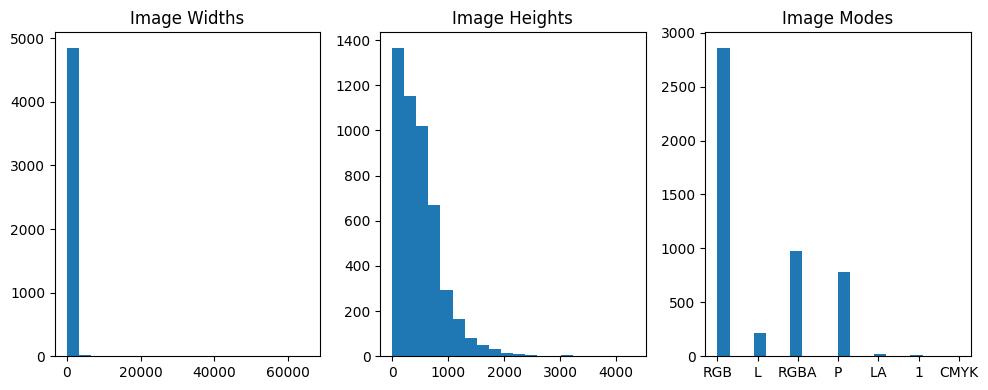

In [13]:
# Execute EDA functions
image_properties(img_paths)

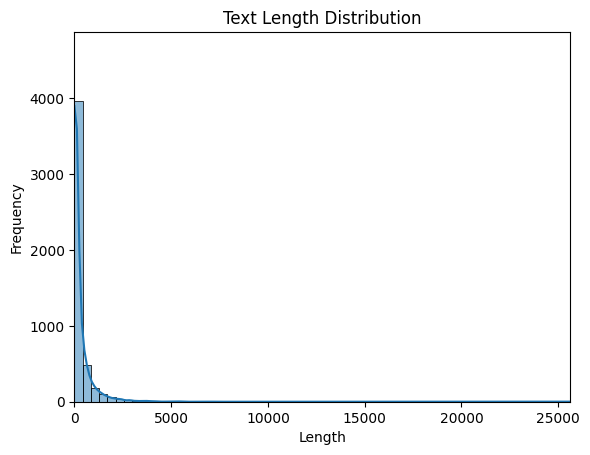

In [14]:
# Execute EDA functions
num_img=len(img_paths)
text_length_distribution(texts, num_img)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


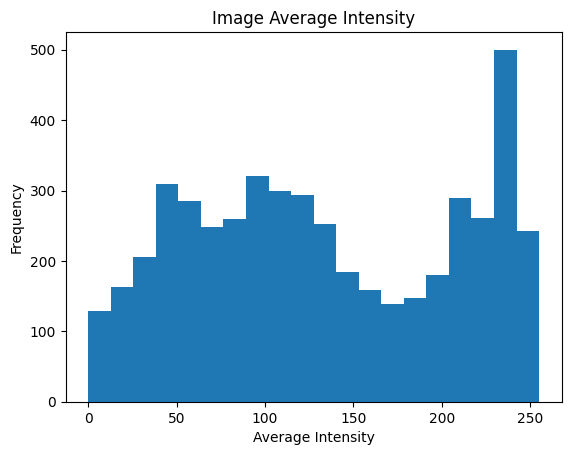

In [15]:
# Execute EDA functions
image_quality(img_paths)

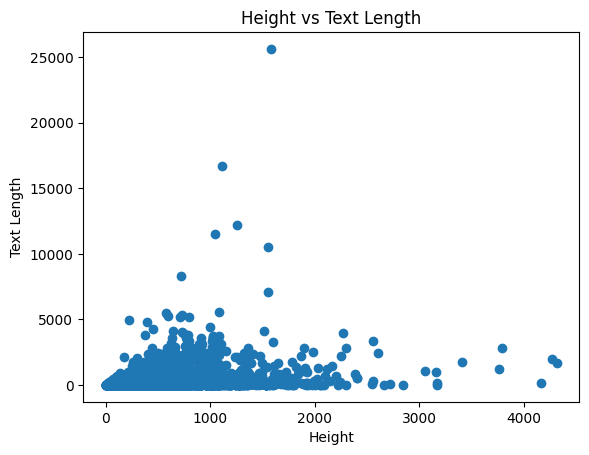

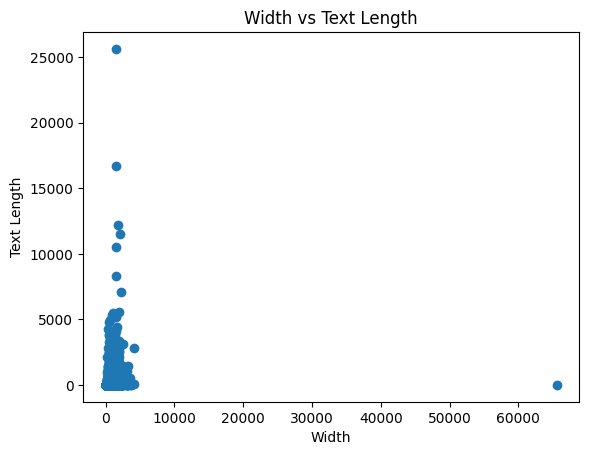

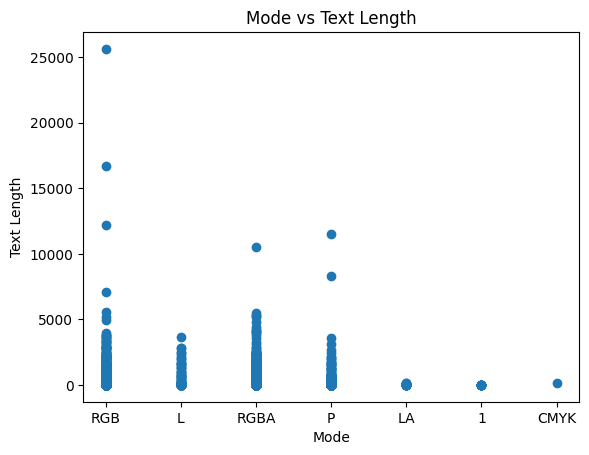

In [16]:
# Execute EDA functions
plot_image_properties_vs_text(img_paths, texts)

In [17]:
type(texts[0])

dict

In [18]:
print(texts[0])

{'ocr_text_info': {'all_text': 'Aloha\nW LEREEE\n3imL.\nT19\nucket\nAIR CALIFORNIA\nS storeshare.\nexgu\nLana\nBXS\noptegraPIS\nGrod\nnates\n', 'is_arabic': False}, 'safe_search': {'medical': 1, 'spoof': 1, 'violence': 1, 'adult': 1}, 'size': {'width': 1024, 'height': 744}, 'text': 'Aloha\nW LEREEE\n3imL.\nT19\nucket\nAIR CALIFORNIA\nS storeshare.\nexgu\nLana\nBXS\noptegraPIS\nGrod\nnates\n', 'is_emoji': False}


In [19]:
fields_counts = explore_unique_fields(texts)
for field, count in fields_counts.items():
    print(f"Field: {field} ----- Count: {count}")

Field: ocr_text_info_all_text ----- Count: 2110
Field: ocr_text_info_is_arabic ----- Count: 2524
Field: safe_search_medical ----- Count: 4868
Field: safe_search_spoof ----- Count: 4868
Field: safe_search_violence ----- Count: 4868
Field: safe_search_adult ----- Count: 4868
Field: size_width ----- Count: 4859
Field: size_height ----- Count: 4859
Field: text ----- Count: 4868
Field: is_emoji ----- Count: 2817


In [20]:
print(f"Image count: {len(img_paths)}")
print(f"Texts count: {len(texts)}")

Image count: 4868
Texts count: 4868


----------Texts with length over 1000----------


WARBIRDS SERIES
DRAGON
The Avea Wcan played an ipotani le s stalg bonter Fon 1969 0 14 For more hen 30 years dong he begh Be Cold Wa
trat amedwth nuder bonbs wasmady la deler feegn natons such es be Soviel Uhon fom aacing Great Brtein Operaled by he Voonber
coss-section made Edes for penetrating eny arigace le delver ts noclear paoed should the need bave aen Alots of 134 Vcas wert
manuadured, with econd tranche kiown a he 2 being he mod comon Aloal of4581 and 82 arct were produced up 15
The 82 featured larger and thinner wngs hlea geter fuel capecity ofered a ousng
electonics and rada This indudes, bo he nid 1s onrds teinolovng radane nodecne ad a pasve reder waning syslen ie he
tn Late e . he Aro Mcan wi d for conertional bombing mons ost sotcesly apnt Argentira darng he Falands Var of 192
Far tvee decades the Wiean ployed an nponant le in he Cold Wir before ws ventualy sigerseded by he Tanad
eof TAn. Eaise hed eproved equpmeni such as

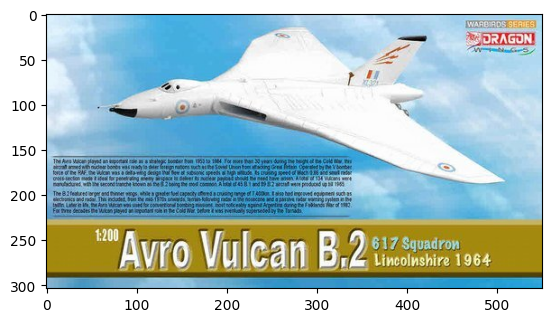

-----------------------------------------------------------------


8 https://www.diecastaircraftforum.com/showthread.php?p=2782288&posted=1#post2782288
田
XAnet Anet pics O FR24
O Rota
- Bmail
Bos Hotm M Gmail A 400
O YT
W wiki
O EGPF
E Taobao
ebay
a Amzn
C/tax
. Flickr
ab ARD
M Magpie
xe XE
Today, 017 PM
5 (permalink)
E Re: Cookles permission popup notice on site
Big Al
17 years collecting
Quote:
Originally Posted by vs-Admin a
Do you have any form of ad blocker, cookie blocker, or tracking blocker added to your browser? What browser are you using?
Kevin
Welcome to DiecastAircraftForum.com
Not that I'm aware of Kevin ?
en on my Chrome browser/phone.
Doin Date: Feb 2005
Location: Near GLA
Posts: 5.958
In support of our communities, we and our 3rd party
partners set cookies to deliver personalized content
and ads.
Let's be having, the Bri
edit quete . quick
post reply
By continuing to use this forum, including clicking the 'OK, understood!
button below, you consent to the use of collect

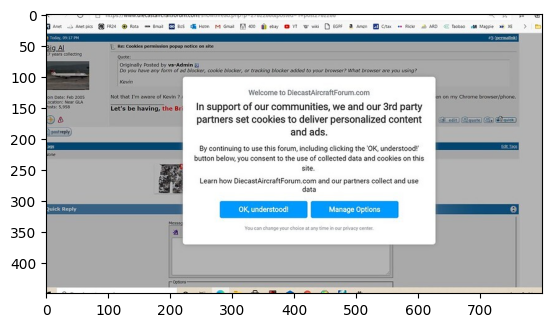

-----------------------------------------------------------------


Аудитория
Это видео отмечено как не предназначенное для детей Задано вами
указывать эту информацию требуется в целях соблюдения Закона США о защите
личных сведений детей в Интернете (COPPA) и/или других законодательных актов.
Требование распространяется на всех авторов независимо от страны проживания.
Подробнее о том, как определить, предназначен ли контент для детей,
рассказывается в Справочном центре.
В контенте для детей недоступны некоторые функции, например уведомления и
персонализированная реклама. Если видео предназначено для детей, лучше,
чтобы автор сам указал целевую аудиторию. Тогда оно с большей вероятностью
будет рекомендовано зрителям, которые смотрят подобный контент. Подробнее
Видео для детей
Видео не для детей
Возрастные ограничения (дополнительно)
Указать, что ролик предназначен только для взрослой аудитории?
Видео, предназначенные только для зрителей старше 18 лет, показываются не во
всех разделах Yo

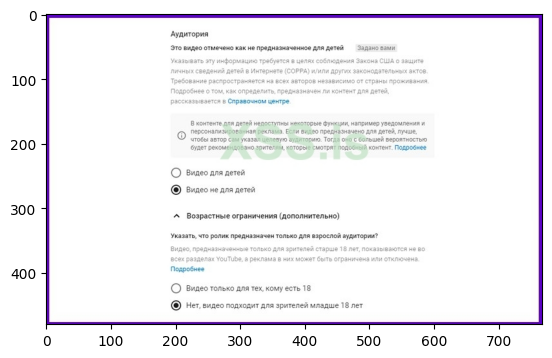

-----------------------------------------------------------------


3002074973, 16618259,"CLASICA NACIONAL VISA", 4555001074931162,"EVANGELIN ALFARO GONZALEZ",,,,"GOYA 566",, PROVIDENCIA, GUADALAJARA, JAL, 44630,013,6425842," "
3002074974, 16618261,"EMPRESARIAL NACIONAL VISA", 4555060120918367,"FEDERICO ALFARO HERNANDEZ", FEDERICO, ALFARO, HERNANDEZ, "NADRO SA DE CV",,"LONDRES 107 PS-8 JUAREZ", CUAUHTEMOC, DF, 06600,,2072055, M
3002074975, 16618263,"EMPRESARIAL NACIONAL VISA", 4555060120917815,"ALFONSO ALFARO I", ALFONSO, ALFARO, I, "EDITORIAL TRILLAS SA DE CV",, "RIO CHURUBUSCO 385 GRAL", "BENITO JUAREZ", DF,03340, 688, 4233138, M
3002074976, 16618265, "ORO INTERNACIONAL VISA", 4555400103959907, "MIGUEL A ALFARO J", "MIGUEL A", ALFARO, J,"AVE INSURGENTES","102 COL","JOSE LOPEZ PORTILLO","CHETUMAL O BLANCO", QRO, 77000, 019, 8370988, M
3002074977, 16618267, "APROVACION GARANTIZADA MASTERC", 5445510152054367,"ADRIAN SERGI ALFARO LOPEZ",,,, BOKOBA, 221,"PEDREG SAN NICOLAS", TLALPAN, DF, 

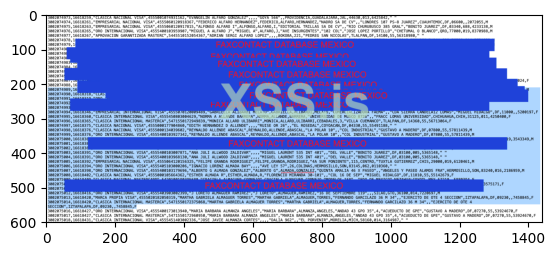

-----------------------------------------------------------------


О Мессенджер
A vk.com/im?sel=c168
а Поиск
к м Моргенштрн — Новый трек
Александр
АМоя страница
Общий чат
< Назад
276 участников
О Мессенджер
В Новости
О Мессенджер
Telegram Soft 20 мар в 19:28
A vk.com/im?sel=c168
8
Обновление 20.0з.2020: http://info.telegram-soft.ru/changelog/20_03_2020 п
е Друзья
..790
Управление
Александр Аменовский 16:55
Сообщества
ла
XSS.j:
О Фотографии
да
Все участники 276
Администраторы 4
Л Музыка
это и есть сесии софта
Видео
+ Добавить участников
В Клипы
Игры
Сергей Голодов 17:07
Создатель бе
заново открыть ни как?
В Тelegram Soft
н Мини-приложения
Александр Аменовский 17:09
Pavel Ivanov
Админист
Работа
регать в ручном режиме с тдаты копируя код
был в сети три часа назад
Александр Аменовский 19-44
Маркет
Кирилл Корнеев
Админист
олег дилеров напиши в лс свою тг
был в сети вчера в 19:09
k Закладки
Александр Мухин 20:38
Александр Аменовский
Администрато
Файлы
кто парсит номера с оlx напишите в ЛС
o

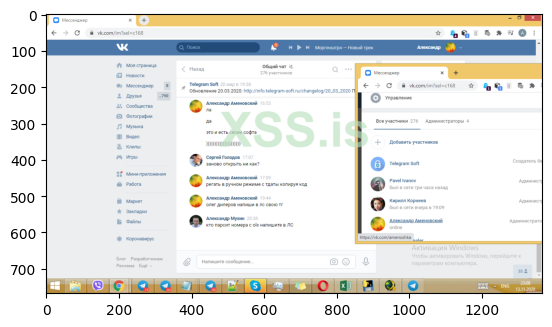

-----------------------------------------------------------------



----------Images with width over 5000 or height over 3000----------


Path: /content/drive/MyDrive/Data/Data_samples/forum_cncnz/5066ef21337a923ff37f3e5ec5f7d838.jpg, Width: 3167, Height: 3167 




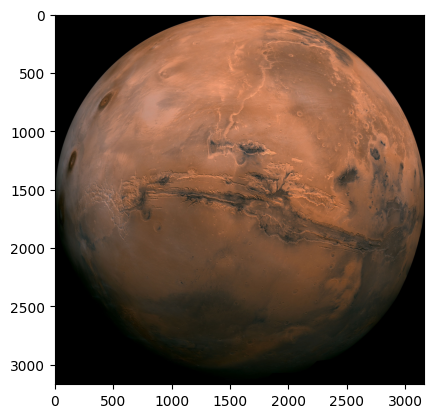

Path: /content/drive/MyDrive/Data/Data_samples/forum_ashiyane/01d5255f5261b1dab6c19775c0dbc34c.jpg, Width: 910, Height: 3792 




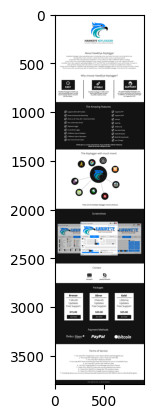

Path: /content/drive/MyDrive/Data/Data_samples/forum_bglife/4d1f69a0e7214e7d3872438752d3f8fd.jpg, Width: 2233, Height: 3155 




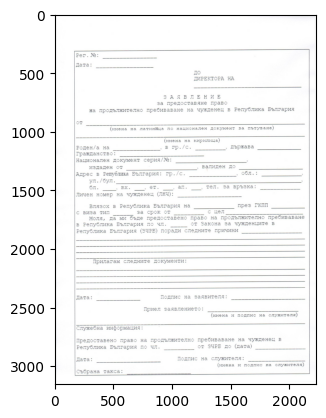

Path: /content/drive/MyDrive/Data/Data_samples/forum_digitalkaos/001a28d2b0815ba3fd6673799cbb5039.jpg, Width: 3120, Height: 4160 




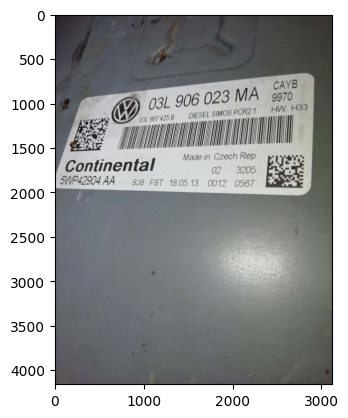

Path: /content/drive/MyDrive/Data/Data_samples/forum_forumkorner/194c67e465efeebe0a57bd030a424128.jpg, Width: 3167, Height: 3167 




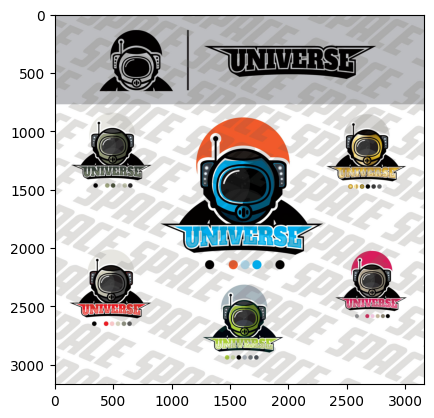

-------------------------------DONE!!!--------------------------------


In [21]:
# Execute EDA functions
find_anomalies(img_paths, texts);

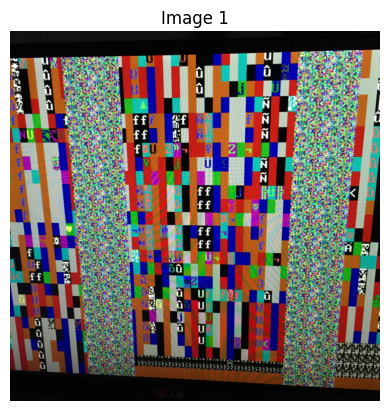

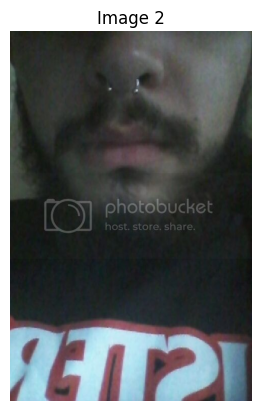

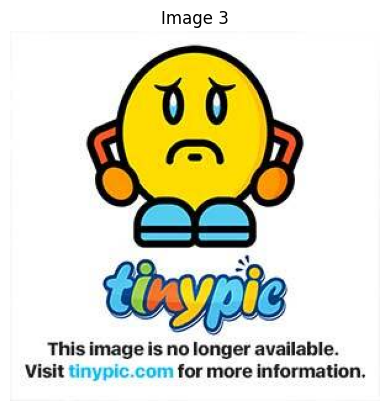

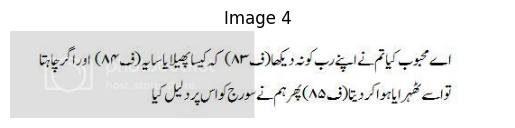

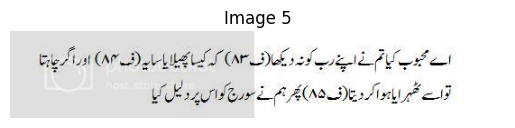

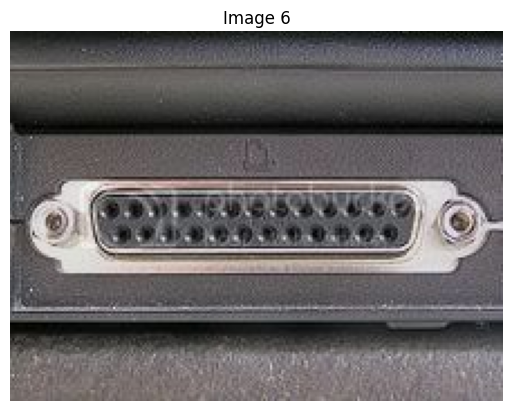

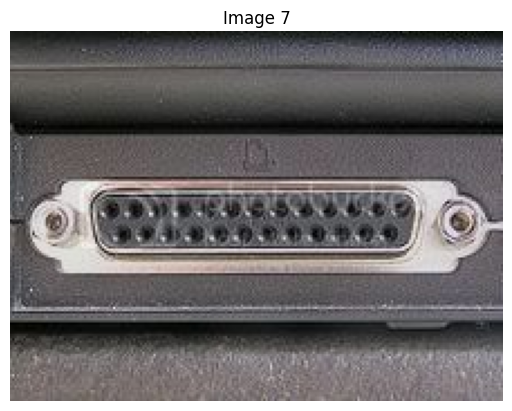

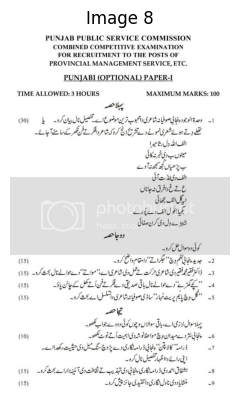

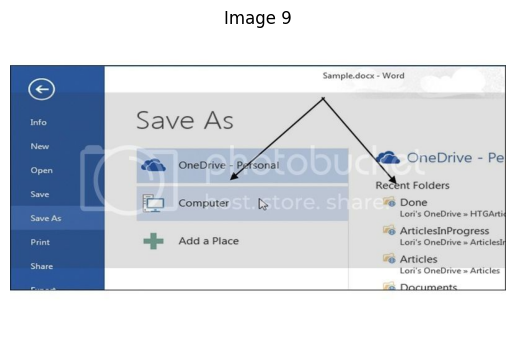

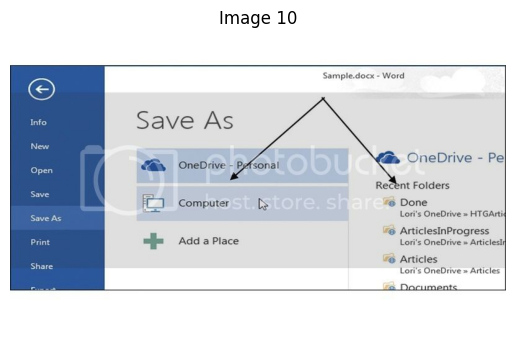

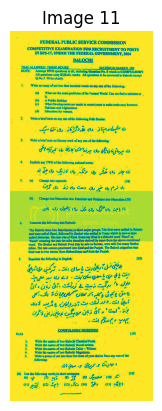

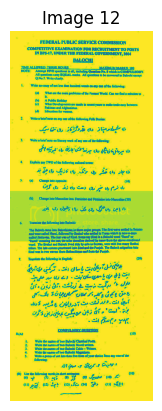

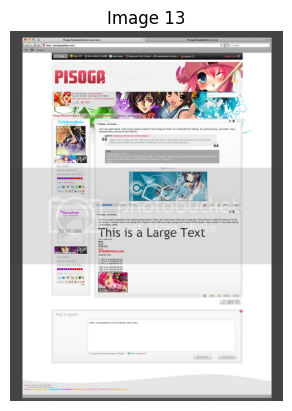

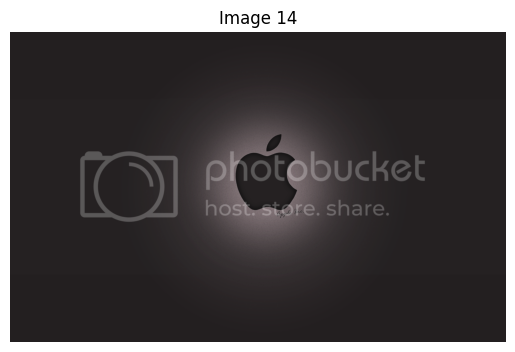

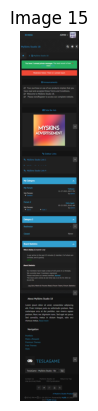

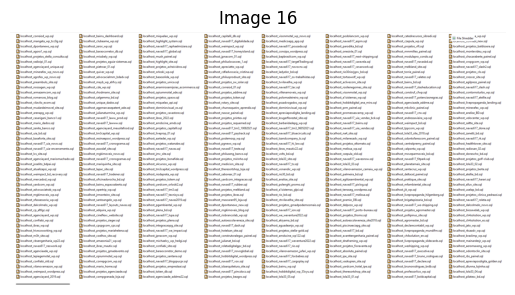

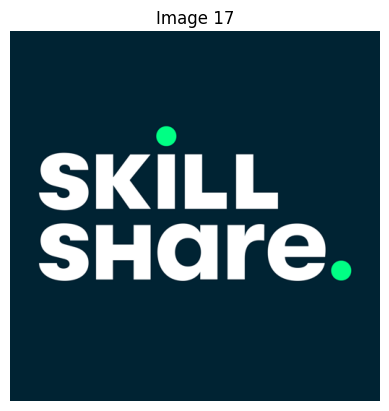

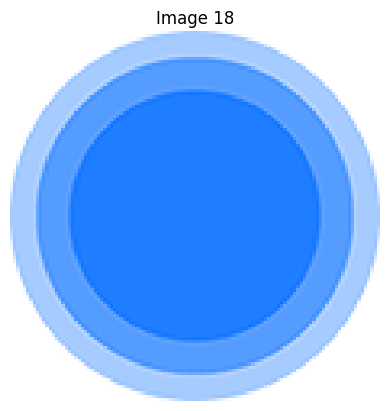

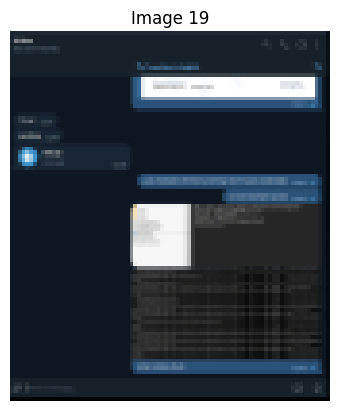

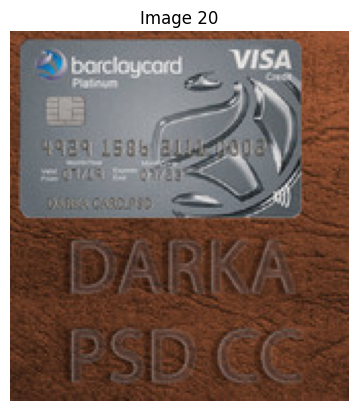

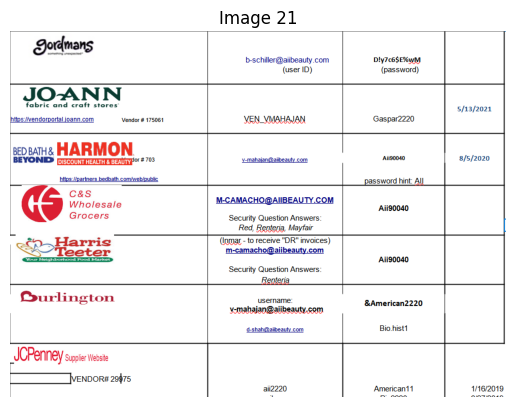

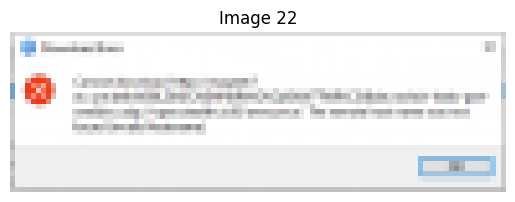

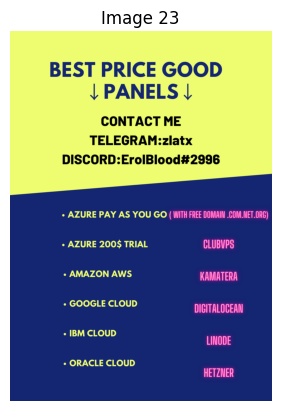

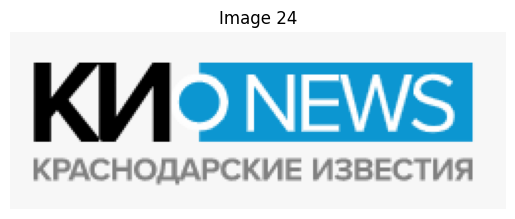

(24,
 ['/content/drive/MyDrive/Data/Data_samples/forum_forumkorner/1723061f0c317f2faa27f9193bb70e9d (1).jpg',
  '/content/drive/MyDrive/Data/Data_samples/forum_forumkorner/1fac3bae0a135b4ef68b3fc32a8c0404 (1).jpg',
  '/content/drive/MyDrive/Data/Data_samples/forum_forumkorner/37e9a9fca564bd196adff802f739ec81 (1).jpg',
  '/content/drive/MyDrive/Data/Data_samples/forum_cssforum/0158efb0a1beb8cb37b1064fdb8d899c (2).jpg',
  '/content/drive/MyDrive/Data/Data_samples/forum_cssforum/0158efb0a1beb8cb37b1064fdb8d899c (1).jpg',
  '/content/drive/MyDrive/Data/Data_samples/forum_cssforum/01e9cf7428895ddd0d5a7d4c4fa9ba73 (2).jpg',
  '/content/drive/MyDrive/Data/Data_samples/forum_cssforum/01e9cf7428895ddd0d5a7d4c4fa9ba73 (1).jpg',
  '/content/drive/MyDrive/Data/Data_samples/forum_cssforum/01f2879ce9645ec7f57bfcc53e91c3b8 (1).jpg',
  '/content/drive/MyDrive/Data/Data_samples/forum_cssforum/025bd48880e71f48c0fe791e3f28395c (2).jpg',
  '/content/drive/MyDrive/Data/Data_samples/forum_cssforum/025bd4888

In [22]:
# Execute EDA functions
find_images_without_json(root_folder=root_folder)